<a href="https://colab.research.google.com/github/dtht2d/deep-learning/blob/main/codes/face-recognition/practical_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 30

Autosaving every 30 seconds


# **Fine-tuning VGG19 for Face Recognition: Analysis of Genuine and Impostor Scores, ROC Curve, and Threshold Optimization**

# **Objective**
Fine-tune a VGG19 with 70% of the data[1]
(7 images of each identity) and then use fc7 output as features (do away with classification head but after training-see MATLAB help for “activations” to see how you can get the outputs of an intermediate layer). Using the remaining 3 images per identity (30% validation, that would be images 8, 9, and 10 for each subject), and cosine similarity between enrollment (first validation image, #8) and verifications (second and third images from validation, images #9 and #10), create genuine and impostor score sets and plot their distributions (histograms) and ROC of these two classes (include AUC) for training and testing subsets [2]

Cosine similarity between vesctors X and Y is given by 
$$
cos(\theta)==\frac{\sum{x_i*y_i}}{\sqrt{\sum{x^2_i}}*\sqrt{\sum{y^2_i}}}
$$

**Other tasks**:

- Use ROC curves or score sets, find the threshold for ≈ 1% FAR on the training set, report the threshold and the corresponding training GAR
- Apply that decision threshold to the validation score. Report on the resultig FAR and GAR 
---
[1] AT&T face recognition dataset from https://www.kaggle.com/kasikrit/att-database-of-faces

[2]To generate all permutations for genuine and imposter pairs, say for the test subset, assume the first verification2
feature vector for subject 1 (enrollment reference) is f1_8. Compare it (using cosine similarity) with the remaining 2
feature vectors from subject 1: f1_9, f1_10, and record the cosine similarity scores. Now compare f1_8 with the last 2
verification features of subject 2: f2_9, f2_10, and record the cosine similarity scores. Continue until you compare
f1_8 with the last 2 verification features of the last subject 40: f40_9, f40_10, and record the cosine similarity scores.
Carry out a similar process to generate training genuine and impostor scores.



## **Purpose** 

### Fine-tuning VGG19 for Face Recognition: Analysis of Genuine and Impostor Scores using Cosine Similarity and ROC Curve

1. Feature Extraction: By fine-tuning the VGG19 model and extracting features from the fc7 layer, we obtain a lower-dimensional representation of the images that captures important patterns and discriminative information. This allows us to leverage the pre-trained model's knowledge from a large dataset (ImageNet) and adapt it to our specific task.

2. Verification and Identification: By comparing the enrollment image (a reference image) with the verification images using cosine similarity, we can quantify the similarity between these images. This process is commonly used in face recognition or biometric identification systems to determine whether two images belong to the same person (genuine scores) or different people (impostor scores).

3. Performance Evaluation: Analyzing the distribution of genuine and impostor scores using histograms provides insights into the separability of the features extracted by the model. A well-performing model should have distinct distributions for genuine and impostor scores, indicating that genuine pairs have higher similarity scores than impostor pairs. This evaluation helps understand the model's ability to discriminate between genuine and impostor samples.

    ROC Curve and AUC: The ROC curve is a visual representation of the performance of a binary classification system across different thresholds. It shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity). The AUC (Area Under the Curve) summarizes the overall performance of the classifier, where a higher AUC value indicates better discrimination between genuine and impostor scores. The ROC curve and AUC provide a comprehensive evaluation of the model's ability to separate the two classes.

By following these steps and evaluating the model's performance using metrics like ROC and AUC, you can assess the effectiveness of the fine-tuned VGG19 model for your specific task, understand the separability of the features, and determine its capability to distinguish between genuine and impostor pairs. This analysis is particularly valuable in applications such as biometric recognition or verification systems, where accurate discrimination between individuals is essential.

### Finding the threshold 

The purpose of finding the threshold for approximately 1% False Acceptance Rate (FAR) on the training set and applying it to the validation scores is to assess the performance of the face recognition system at a specific operating point.
- False Acceptance Rate (FAR): FAR represents the probability of the system incorrectly accepting an impostor (mismatched) pair as a genuine match. A lower FAR indicates a more secure system, as it means fewer impostor pairs are falsely accepted.

- Genuine Acceptance Rate (GAR): GAR represents the probability of the system correctly accepting a genuine (matched) pair. A higher GAR indicates a higher accuracy in recognizing genuine pairs.

By finding the threshold for approximately 1% FAR on the training set, we determine the threshold score that achieves a desirable balance between system security and recognition accuracy. This threshold separates the genuine and impostor scores, allowing us to classify them as matches or non-matches.

Applying this threshold to the validation scores allows you to evaluate the system's performance on **unseen data**. We can measure the resulting False Acceptance Rate (FAR) and Genuine Acceptance Rate (GAR) on the validation set, which indicates how well the system performs in real-world scenarios.

By reporting the threshold and the corresponding training GAR, we provide insights into the system's performance at the specified operating point. Similarly, reporting the resulting FAR and GAR on the validation set helps assess the generalization and effectiveness of the system on new data.

Overall, this analysis allows you to fine-tune the system's threshold to achieve a desired balance between security (FAR) and recognition accuracy (GAR) and evaluate its performance on both training and validation data.

## **II. Methods**

## Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/deep-learning/ATT"

In [4]:
import os
import itertools

def getIMAGElist(data_folder, n_class, n_image):
    """
    This function gets a list of images.
    data_folder: contains different class folders.
    n_class: number of class folders to include.
    n_image: number of images to include in each class folder.
    Returns:
        Image list, target name.
    """
    image_list = []
    target_name = []
    with os.scandir(data_folder) as entries:
        for entry in itertools.islice(entries, n_class):
            if not entry.name.startswith('.'):
                with os.scandir(entry.path) as files:
                    for file in itertools.islice(files, n_image):
                        if not file.name.startswith('.'):
                            image_path = os.path.join(data_folder, entry.name, file.name)
                            image_list.append(image_path)
                            target_name.append(entry.name)
    return image_list, target_name

In [5]:
data_folder = path
n_class = 40
n_image = 10
image_list, target_name = getIMAGElist(data_folder,n_class,n_image) 
print (len(image_list))
print (len(target_name))

400
400


In [6]:
import os
import itertools
import cv2
import matplotlib.pyplot as plt

def plot_images(data_folder, n_class, n_image, images_per_row):
    """
    This function plots multiple images from each class in a single plot.
    data_folder: contains different class folders.
    n_class: number of class folders to include.
    n_image: number of images to include in each class folder.
    images_per_row: number of images to display in each row of the plot.
    """
    fig, axs = plt.subplots(n_class, images_per_row, figsize=(12, n_class*3))
    plt.tight_layout()

    with os.scandir(data_folder) as entries:
        for i, entry in enumerate(itertools.islice(entries, n_class)):
            if not entry.name.startswith('.'):
                with os.scandir(entry.path) as files:
                    for j, file in enumerate(itertools.islice(files, n_image)):
                        if not file.name.startswith('.'):
                            image_path = os.path.join(data_folder, entry.name, file.name)
                            image = cv2.imread(image_path)
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            axs[i, j].imshow(image)
                            axs[i, j].axis('off')
                            axs[i, j].set_title(entry.name)
    plt.show()


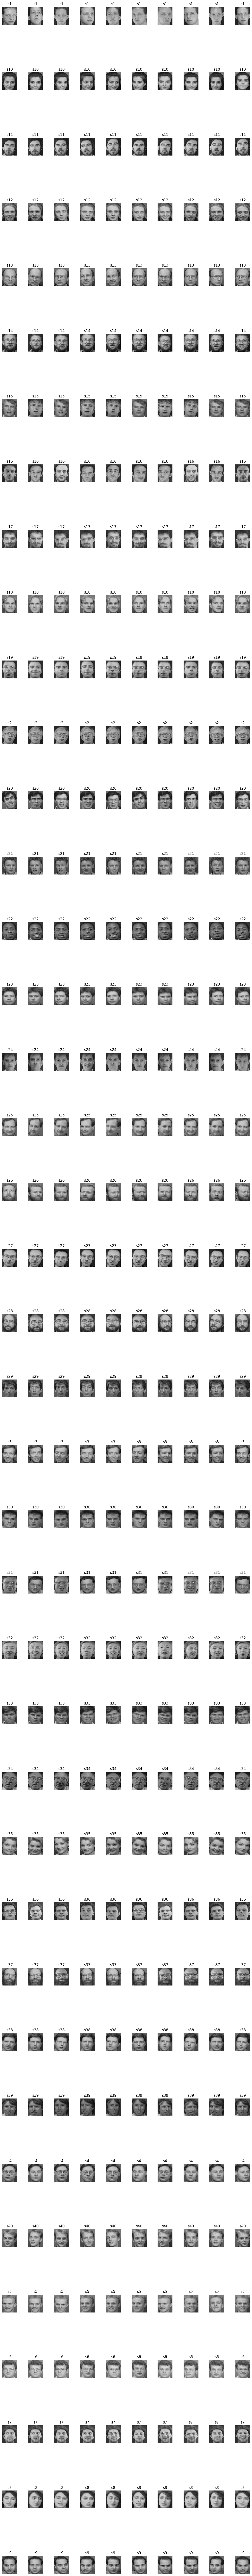

In [7]:
data_folder = path
n_class = 40  # Number of class folders to include
n_image = 10  # Number of images to include in each class folder
images_per_row = 10  # Number of images to display in each row
plot_images(data_folder, n_class, n_image, images_per_row)

## A.Fine-tuning VGG19 for Face Recognition: Analysis of Genuine and Impostor Scores using Cosine Similarity and ROC Curve

###1. Prepare dataset:

Split dataset into two parts: 70% for training and 30% for validation/testing.
Ensure that the images are organized by identity, with 7 images per identity for training and 3 images per identity for validation/testing.**bold text**


In [8]:
import cv2
import numpy as np 
from sklearn.model_selection import train_test_split

data_folder = path
n_class = 40
n_image = 10
image_list, class_name= getIMAGElist(data_folder,n_class,n_image)
image_data=[]
for i in range(len(image_list)):
    image = cv2.imread(image_list[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize image: INTER_AREA-resampling using pixel area relation
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255
    image_data.append(image)
class_dict={k:v for v,k in enumerate(np.unique(class_name))}
class_val= [class_dict[class_name[i]] for i in range(len(class_name))]
x = np.array(image_data)
y = np.array(class_val)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40, stratify=y)

`stratify=y`: maintaining the same class distribution as the original dataset

In [9]:
print (x.shape, y.shape)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(400, 224, 224, 3) (400,)
(280, 224, 224, 3) (280,)
(120, 224, 224, 3) (120,)


Check $y_{test}$ which include images class ID to see if the testing set split correctly where we need 3 images per identity 

In [10]:
# Find the count of each unique element
unique_elements, counts = np.unique(y_test, return_counts=True)
# Print the count of each unique element
for class_id, count in zip(unique_elements, counts):
    print(f"person_ID {class_id} appears {count} times")

person_ID 0 appears 3 times
person_ID 1 appears 3 times
person_ID 2 appears 3 times
person_ID 3 appears 3 times
person_ID 4 appears 3 times
person_ID 5 appears 3 times
person_ID 6 appears 3 times
person_ID 7 appears 3 times
person_ID 8 appears 3 times
person_ID 9 appears 3 times
person_ID 10 appears 3 times
person_ID 11 appears 3 times
person_ID 12 appears 3 times
person_ID 13 appears 3 times
person_ID 14 appears 3 times
person_ID 15 appears 3 times
person_ID 16 appears 3 times
person_ID 17 appears 3 times
person_ID 18 appears 3 times
person_ID 19 appears 3 times
person_ID 20 appears 3 times
person_ID 21 appears 3 times
person_ID 22 appears 3 times
person_ID 23 appears 3 times
person_ID 24 appears 3 times
person_ID 25 appears 3 times
person_ID 26 appears 3 times
person_ID 27 appears 3 times
person_ID 28 appears 3 times
person_ID 29 appears 3 times
person_ID 30 appears 3 times
person_ID 31 appears 3 times
person_ID 32 appears 3 times
person_ID 33 appears 3 times
person_ID 34 appears 3 t

### 2. Fine-tune VGG19:
- Load the pre-trained VGG19 model.
- Remove the classification head from the model.
- Freeze the weights of the pre-trained layers to prevent them from being updated during training.
- Replace the classification head with a new fully connected layer (fc7) that serves as the output layer.
- Compile the model with loss function (MSE) and optimizer(Adam).
- Train the model using the 70% training subset of data, where each identity has 7 images. Use the fc7 layer output as the target for training.

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

# Load the pre-trained VGG19 model
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Remove the classification head
vgg19.layers.pop()

# Freeze the weights of the pre-trained layers
vgg19.trainable = False

# Replace the classification head with a new fully connected layer (fc7)
fc7 = Dense(512, activation='relu')(vgg19.output)

# Create the modified model
model = Model(inputs=vgg19.input, outputs=fc7)

# Compile the model with mse loss function and  adam optimizer
model.compile(loss='mse', optimizer='adam') 

# Obtain the corresponding fc7 layer outputs for x_train
fc7_outputs_train = model.predict(x_train)

# Train the model using the 70% training subset, use fc7_outputs as the target for training
model.fit(x_train, fc7_outputs_train, epochs=10)  
# Evaluate the model on the training vs fc7_outputs 
evaluation = model.evaluate(x_train,fc7_outputs_train )
print("Evaluation Loss:", evaluation)


9/9 [==============================] - 5s 544ms/step
Epoch 1/10
9/9 [==============================] - 3s 158ms/step - loss: 1.3831e-04
Epoch 2/10
9/9 [==============================] - 1s 158ms/step - loss: 1.0790e-04
Epoch 3/10
9/9 [==============================] - 1s 157ms/step - loss: 3.5070e-05
Epoch 4/10
9/9 [==============================] - 1s 155ms/step - loss: 1.7008e-05
Epoch 5/10
9/9 [==============================] - 1s 155ms/step - loss: 6.5103e-06
Epoch 6/10
9/9 [==============================] - 1s 153ms/step - loss: 2.7601e-06
Epoch 7/10
9/9 [==============================] - 1s 154ms/step - loss: 1.1923e-06
Epoch 8/10
9/9 [==============================] - 1s 156ms/step - loss: 5.2924e-07
Epoch 9/10
9/9 [==============================] - 1s 156ms/step - loss: 2.4616e-07
Epoch 10/10
9/9 [==============================] - 2s 155ms/step - loss: 9.5586e-08
Evaluation Loss: 9.558638680573495e-08


In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 3. Obtain features for testing set (3 images/ class):
Extract the features for the remaining 3 images per identity using the trained VGG19 model.
    

In [17]:
# Obtain the corresponding fc7 layer outputs for x_train
fc7_outputs_test = model.predict(x_test)
print(fc7_outputs_test.shape)

4/4 [==============================] - 1s 156ms/step
(120, 7, 7, 512)


### 4. Compute genuine and impostor scores:
For each identity in the esting subset:
- Take the feature vector of the first image (i.e: #8) and calculate its cosine similarity with the feature vectors of the second and third images (i.e: #9 and #10) from the same identity. Record the cosine similarity scores as genuine scores for this identity.
- Compare the feature vector of the first test image with the feature vectors of the second and third images from all other identities. 
- Record the cosine similarity scores as impostor scores for this identity.
- Repeat the above process for all identities in the testing subset.

In [46]:
#Reshape of fc7_outputs_test features has 120 images/sample, [7x7x512] features/ image
n_sample = fc7_outputs_test.shape[0]
n_feature = np.prod(fc7_outputs_test.shape[1:])  # Compute the product of dimensions 1, 2, and 3
fc7_test_reshape = fc7_outputs_test.reshape((n_sample, n_feature))
print (fc7_test_reshape.shape)

(120, 25088)


Comment: 120 testing images, 25088 features/ images

In [29]:
print (y_test.shape)

(120,)


Get the indices of images with the same identity (we expect during split dataset x_test has 3 images/class)

In [35]:
id_identity_set=[]
for i in range(len(y_test)):
  same_identity_indices = np.where(y_test == y_test[i])[0]
  id_identity_set.append(same_identity_indices)
print (id_identity_set)

[array([ 0, 28, 77]), array([ 1, 24, 89]), array([  2,  55, 113]), array([ 3, 72, 88]), array([ 4, 18, 40]), array([ 5, 19, 98]), array([ 6, 32, 84]), array([ 7, 12, 50]), array([  8,  81, 108]), array([  9,  43, 106]), array([10, 45, 60]), array([11, 63, 74]), array([ 7, 12, 50]), array([13, 36, 82]), array([14, 54, 76]), array([ 15,  92, 104]), array([ 16,  41, 114]), array([17, 85, 90]), array([ 4, 18, 40]), array([ 5, 19, 98]), array([20, 62, 73]), array([ 21, 110, 119]), array([22, 29, 59]), array([ 23,  46, 105]), array([ 1, 24, 89]), array([25, 27, 51]), array([ 26,  61, 109]), array([25, 27, 51]), array([ 0, 28, 77]), array([22, 29, 59]), array([ 30,  95, 100]), array([31, 35, 71]), array([ 6, 32, 84]), array([ 33,  52, 111]), array([ 34,  65, 103]), array([31, 35, 71]), array([13, 36, 82]), array([37, 48, 93]), array([ 38,  57, 112]), array([ 39,  70, 116]), array([ 4, 18, 40]), array([ 16,  41, 114]), array([42, 49, 80]), array([  9,  43, 106]), array([44, 69, 94]), array([10

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
genuine_scores = []
impostor_scores = []

for i in range(len(y_test)):
    # Get the indices of images with the same identity as the current image
    same_identity_indices = np.where(y_test == y_test[i])[0]

    # Calculate cosine similarity between the feature vector of the first image and the second and third images of the same identity
    genuine_similarity = cosine_similarity(fc7_test_reshape[i].reshape(1, -1), fc7_test_reshape[same_identity_indices[1:]])

    # Calculate cosine similarity between the feature vector of the first image and the second and third images of other identities
    impostor_similarity = cosine_similarity(fc7_test_reshape[i].reshape(1, -1), fc7_test_reshape[np.where(y_test != y_test[i])])

    # Record the cosine similarity scores as genuine and impostor scores
    genuine_scores.append(genuine_similarity.flatten())
    impostor_scores.append(impostor_similarity.flatten())

genuine_scores = np.concatenate(genuine_scores)
impostor_scores = np.concatenate(impostor_scores)


In [ ]:
for i in len(range(fc7_outputs_train))

### 5.Create histograms and ROC curves:
- Plot the histograms of the genuine and impostor scores separately for the training and testing subsets. This will show the distribution of scores for each class.
- Calculate the Area Under the Curve (AUC) for the Receiver Operating Characteristic (ROC) curve for both the training and testing subsets.
- Plot the ROC curves for the training and testing subsets, using the genuine and impostor scores obtained.